# Lending Club Loan Analysis: Building a Risk Model Based on Loan Attributes 

## Contents
* <a href='#Synopsis'>Synopsis</a>
* <a href='#Lending Club Dataset'>Lending Club Dataset</a>
* <a href='#Exploring the Data'>Exploring the Data</a>
* <a href='#Building the Model'>Building the Model</a>
* <a href='#Conclusion'>Conclusion</a>

<a id='Synopsis'></a>

## Synopsis
LendingClub is a platform for crowdsourcing loans. Applicants request loans which are reviewed by LendingClub in order to filter out risky loans. Loans are then rank on likelihood of defaulting based on the applicants FICO score and information  and an interest rate is selected based on risk. Lenders are able to build a portfolio composed of partial funding of hundreds of loans or individually selected loans to fund. 

We would like to build a similar ranking model based on information from loans issued between 2007 and 2015.
### Includ info from the model

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)

<a id='Lending Club Dataset'></a>

## Lending Club Dataset

The Data set contains all loans approved by LendingClub between 2007 and 2015. The Lending Club requires applicants to have a FICO score of 640 and a maximum debt to income ratio (dti) of 30% (excluding mortgage.) Only about 20% of applicants meet their criteria.

In [2]:
loan_data = pd.read_csv('loan.csv', low_memory = False)
loan_data.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
loan_data[['int_rate', 'annual_inc', 'loan_amnt', 'funded_amnt', 'dti']].describe()

/Users/kyleschlicht/anaconda/envs/python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,int_rate,annual_inc,loan_amnt,funded_amnt,dti
count,887379.000000,8.873750e+05,887379.000000,887379.000000,887379.000000
mean,13.246740,7.502759e+04,14755.264605,14741.877625,18.157039
std,4.381867,6.469830e+04,8435.455601,8429.897657,17.190626
min,5.320000,0.000000e+00,500.000000,500.000000,0.000000
25%,9.990000,NaN,8000.000000,8000.000000,11.910000
50%,12.990000,NaN,13000.000000,13000.000000,17.650000
75%,16.200000,NaN,20000.000000,20000.000000,23.950000
max,28.990000,9.500000e+06,35000.000000,35000.000000,9999.000000


Seems that the max annual income and dti might be errors. I can't imagine why someone with an annual income of 10 million would want a loan that is $35,000 or less and getting in debt 100x more than your annual income seems unlikely (unless that person is recently unemployed)

<a id='Exploring the Data'></a>

## Exploring the Data

## Loan Amount

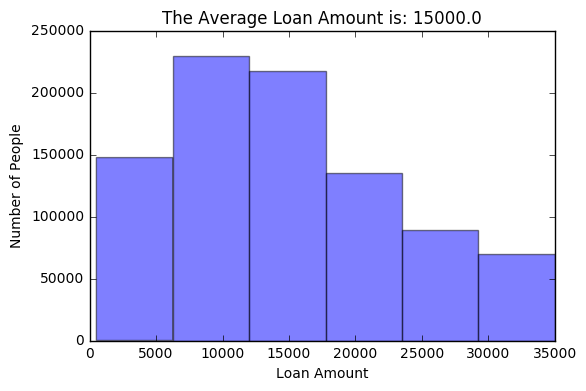

In [4]:
loan_amnt = loan_data['loan_amnt'].copy()
funded_amnt = loan_data['funded_amnt'].copy()



plt.hist(loan_amnt, 6, alpha =0.5)

plt.title("The Average Loan Amount is: {}".format(round(loan_amnt.mean(), -3)))
plt.xlabel("Loan Amount")
plt.ylabel("Number of People")

plt.show()

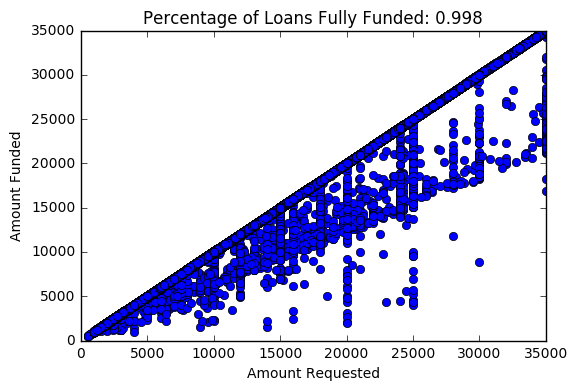

In [5]:
percentage = loan_data[loan_data['loan_amnt'] == loan_data['funded_amnt']]['id'].count()/len(loan_data['id'])

plt.plot(loan_data['loan_amnt'], loan_data['funded_amnt'], 'o')

plt.title("Percentage of Loans Fully Funded: {:.3f}".format(percentage))
plt.xlabel("Amount Requested")
plt.ylabel("Amount Funded")

plt.show()

Nearly every loan is fully funded. This suggests that the demand for loans to fund is essentially equal to or greater than the supply of loans. 

## Issued Date 

Let's convert the date that the loans are issued to a numerical value for easier processing and simply to simply year issued.

In [6]:
#Convert Date to Year
loan_data.issue_d = pd.to_datetime(loan_data.issue_d).apply(lambda x : x.year)
loan_data['issue_d'] = loan_data.issue_d -2007

Unfortunately, since the term length of a loan can be 60 months and the data was collected at the end of 2015. So let's restrict our data to loans issued during or before 2010 since we know whether or not they defaulted. This will limit our sample size from 450000 to just 35000 loans, but that should be large enough to detect trends in the data.

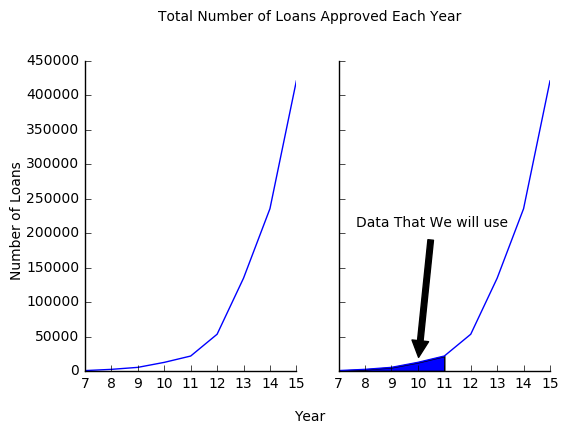

In [7]:
fig, axs = plt.subplots(1,2, sharey=True)

years = np.arange(7, 16, 1)

for i in range(2):
    axs[i].plot(years, loan_data.groupby('issue_d')['issue_d'].count())
    
    #Formatting
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].xaxis.set_ticks_position('bottom')
    axs[i].yaxis.set_ticks_position('left')
    
axs[1].fill_between([7, 8, 9, 10, 11], 0, loan_data.groupby('issue_d')['id'].count()[:5])    
axs[1].annotate('Data That We will use', xy=(10, 10000),  xycoords='data',
            xytext=(0.8, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

#Title and Labels
fig.text(0.5, 1, 'Total Number of Loans Approved Each Year', ha='center')
fig.text(0.5, 0.0, 'Year', ha='center')
fig.text(0.0, 0.5, 'Number of Loans', va='center', rotation='vertical')

plt.show()

Let's simplify our indicator of whether or not a loan defaults

In [8]:
loan_data = loan_data[loan_data['issue_d']<=3]

In [9]:
loan_data = loan_data.loc[loan_data.loan_status.isin({'Fully Paid', 'Charged Off', 'Default', 'Late (31-120 days)'})]
loan_data['paid_off'] = loan_data['loan_status'].map({'Fully Paid' : 1, 'Charged Off' : 0, 'Default' : 0, 'Late (31-120 days)' : 0})
del loan_data['loan_status']

## Why are people requesting loans?

The vast majority of loans are for consolidating debt. The greatest chance of default occurs with business which is reasonable since the majority of businesses fail.

In [10]:
loan_data.groupby('purpose')['paid_off'].agg(['count', 'mean'])

,count,mean
purpose,,
car,613,0.898858
credit_card,2317,0.905913
debt_consolidation,8000,0.866250
educational,325,0.827692
home_improvement,1304,0.882669
house,166,0.825301
major_purchase,1109,0.892696
medical,313,0.859425
moving,279,0.878136


In [11]:
# a good indicator is whether or not the purpose is for a small business
loan_data['is_small_business'] = loan_data['purpose'] == 'small_business'
loan_data['is_small_business'] = loan_data['is_small_business'].map({True : 1, False : 0})
del loan_data['purpose']

## Loan Grades

The grades range from A to G (in decreasing likelihood of repayment) with interest rates increasing from 5.3% to 29%

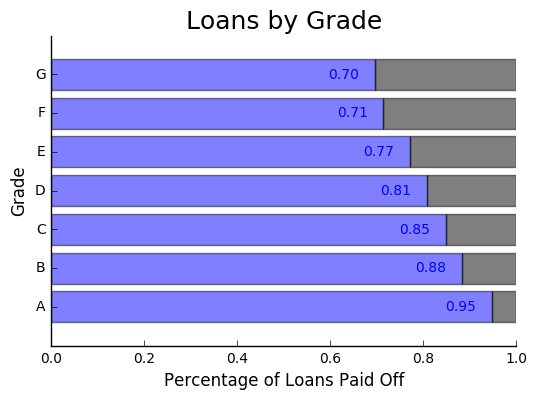

In [12]:
fully_paid = loan_data.groupby('grade').paid_off.mean()
charged_off = 1 - fully_paid
plt.barh(np.arange(len(fully_paid)), fully_paid , align="center", color = 'b', alpha =0.5)
plt.barh(np.arange(len(charged_off)), charged_off, left= fully_paid, align="center", color = 'k', alpha=0.5)
plt.title("Loans by Grade")

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.yticks(np.arange(len(grades)), grades)

plt.ylabel("Grade")
plt.xlabel("Percentage of Loans Paid Off")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax.title.set_fontsize(18)
ax.yaxis.label.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)

for i, v in enumerate(fully_paid):
    ax.text(v - .1, i-0.1, "{:.2f}".format(v), color='b')
    
plt.show()

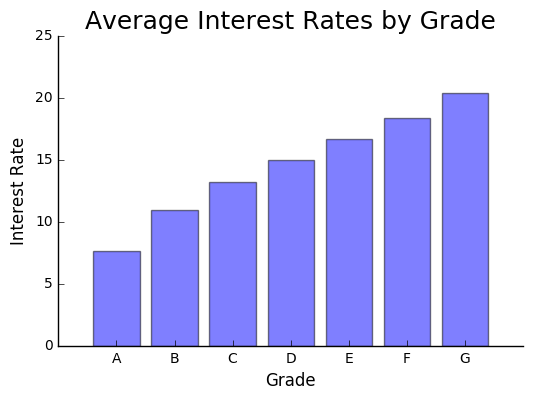

In [13]:
int_rate = loan_data.groupby('grade').int_rate.mean()

plt.bar(np.arange(len(fully_paid)), int_rate, align="center", color = 'b', alpha =0.5)
plt.title("Average Interest Rates by Grade")

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.xticks(np.arange(len(grades)), grades)

plt.xlabel("Grade")
plt.ylabel("Interest Rate")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.title.set_fontsize(18)
ax.yaxis.label.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)
    
plt.show()

## Employment

Most applicants either have a short employment history (<= 3 years) or a long history of employment (10+ years)

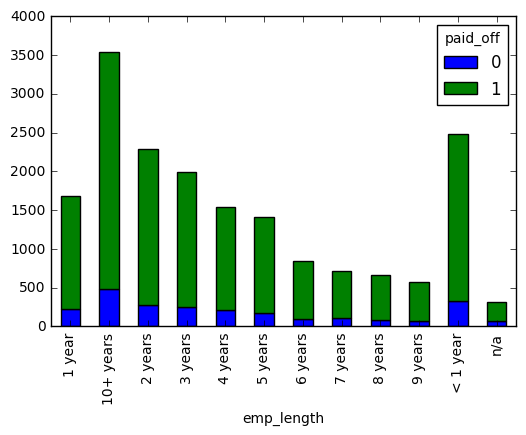

In [14]:
emp_data = loan_data.groupby(['emp_length', 'paid_off'])['emp_length'].count().unstack()
emp_data[[0, 1]].plot(kind='bar', stacked=True)

Converted to a format that's easier to use.

In [15]:
loan_data.emp_length = loan_data.emp_length.map({'n/a': -1, '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10})

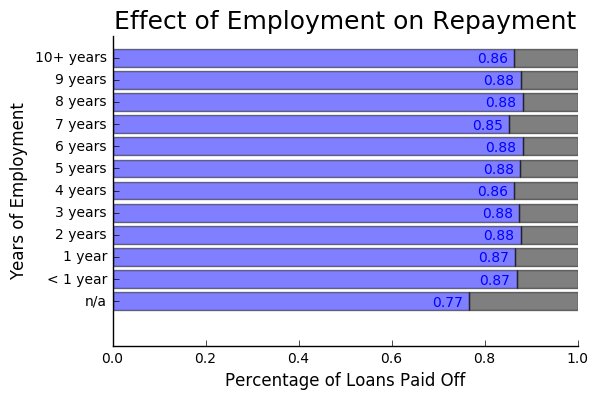

In [16]:
fully_paid = loan_data.groupby('emp_length').paid_off.mean()
charged_off = 1 - fully_paid
plt.barh(np.arange(len(fully_paid)), fully_paid , align="center", color = 'b', alpha =0.5)
plt.barh(np.arange(len(charged_off)), charged_off, left= fully_paid, align="center", color = 'k', alpha=0.5)
plt.title("Effect of Employment on Repayment")

years = ['n/a', '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

plt.yticks(np.arange(len(years)), years)

plt.ylabel("Years of Employment")
plt.xlabel("Percentage of Loans Paid Off")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax.title.set_fontsize(18)
ax.yaxis.label.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)

for i, v in enumerate(fully_paid):
    ax.text(v - .08, i-0.23, "{:.2f}".format(v), color='b')
    
plt.show()

There's only a statistically significance difference in likelihood to default from whether or not someone fills out their employment history (p << 0.05) but there is no significance between different years of employment. Therefore we will only keep track of whether or not someone fills out employment.

In [17]:
loan_data['emp'] = loan_data['emp_length'] >= 0
loan_data['is_emp'] = loan_data.emp.map({True : 1, False : 0})
del loan_data['emp_length']

In [18]:
from scipy.stats import ttest_ind
employed = loan_data[loan_data.is_emp == 1].paid_off
unemployed = loan_data[loan_data.is_emp == 0].paid_off
ttest_ind(employed, unemployed)

Ttest_indResult(statistic=5.3894956104611982, pvalue=7.1541839038930062e-08)

## Home Ownership

No statistical significance was determined for home ownership

In [19]:
del loan_data['home_ownership']

## Income

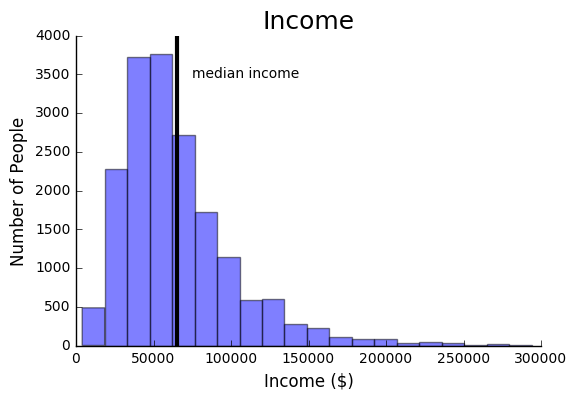

In [20]:
income = loan_data['annual_inc'].copy()

# Remove outliers. Several incomes are reported at over 1 million
income = income[income < 300000]

plt.hist(income, 20, alpha =0.5)
plt.axvline(income.mean(), color = 'k', linewidth=3)

plt.title("Income")
plt.xlabel("Income ($)")
plt.ylabel("Number of People")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.title.set_fontsize(18)
ax.yaxis.label.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)

plt.annotate('median income', xy=(1000, 300),  xycoords='data',
            xytext=(0.48, 0.9), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top')

plt.show()

The median income is \$65k while the nation average income is $30k. I suspect that's because lower income applicants are less likely to qualify for loans.

In [21]:
# The incremental increase in income becomes less significant as income increases.
# (i.e. a $5,000 raise is far more significant when income is $20k than $150k)
loan_data['log_of_annual_inc'] = np.log(loan_data['annual_inc'])
del loan_data['annual_inc']

## Debt to Income Ratio

In [22]:
loan_data['dti'] = loan_data['dti']/100

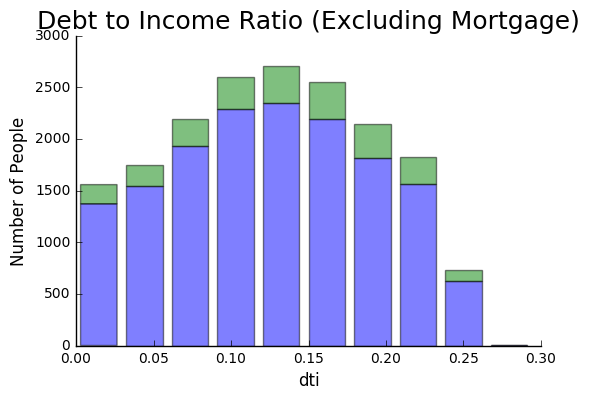

In [23]:
dti_paidoff =loan_data[loan_data['paid_off'] == 1].dti
dti_default =loan_data[loan_data['paid_off'] == 0].dti

plt.hist([dti_paidoff, dti_default], bins = 10, alpha =0.5, stacked=True)

plt.title("Debt to Income Ratio (Excluding Mortgage)")
plt.xlabel("dti")
plt.ylabel("Number of People")

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.title.set_fontsize(18)
ax.yaxis.label.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)

#ax.legend()

plt.show()

## Cleaning Other Attributes

In [24]:
# Many of the attributes were added December of 2015. Since that's the last month of the data set, 
# no inference on the default rate can be extracted from that data so let's remove those columns.
# Also, I'm removing some attributes that I had not explored because of limited time.
loan_data = loan_data[['loan_amnt', 'term', 'int_rate', 'grade', 'issue_d', 'paid_off', 'is_emp', 'earliest_cr_line', 'application_type', 'log_of_annual_inc', 'is_small_business', 'dti', 'revol_util', 'inq_last_6mths']]

# Converts length of loans to integers
loan_data.term = loan_data.term.map({' 36 months' : 36, ' 60 months' : 60})

# Determines whether or not one or multiple people are applying for a loan
loan_data['is_joint'] = loan_data.application_type.map({'INDIVIDUAL':0, 'JOINT':1})
del loan_data['application_type']

# Converts year of first having credit to number of years of credit.
loan_data.earliest_cr_line = pd.to_datetime(loan_data.earliest_cr_line).apply(lambda x : x. year)
loan_data['earliest_cr_ln_before_issue_d'] = loan_data['issue_d'] - loan_data['earliest_cr_line'] + 2007
del loan_data['earliest_cr_line']

# REVOL UTIL (the percentage of available credit used)
loan_data['revol_util'] = loan_data['revol_util']/100
loan_data['revol_util'] = loan_data['revol_util'].fillna(loan_data['revol_util'].mean())

loan_data.head()

,loan_amnt,term,int_rate,grade,issue_d,paid_off,is_emp,log_of_annual_inc,is_small_business,dti,revol_util,inq_last_6mths,is_joint,earliest_cr_ln_before_issue_d
21494,20000.0,60,9.99,B,3,1,1,10.714418,0,0.1336,0.395,2.0,0,21
21517,7475.0,60,13.72,C,3,1,1,11.884489,0,0.1739,0.448,1.0,0,12
21528,5575.0,36,15.20,D,3,1,1,11.695247,1,0.1640,0.480,1.0,0,14
21530,2150.0,60,14.83,D,3,1,1,11.695247,0,0.0616,0.579,0.0,0,8
21532,7050.0,60,12.98,C,3,1,1,11.849398,0,0.0426,0.002,1.0,0,18


<a id='Building the Model'></a>

## Building the Model

Now let's build a model for predicting whether or not a loan will default. I'm only going to focus on the variables that I already look at because I've varified whether or not they may have predictive abilities. I could have examined the other variables as well and they may also have predictive power, but doing so is tedious and doesn't improve much.

In [25]:
from sklearn.model_selection import train_test_split

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

X = loan_data.copy()

# remove variables that come from Lending Club's predictive model
del X['grade']
del X['int_rate']

# remove the results
del X['paid_off']

# encode categorical variables
X = pd.get_dummies(X)


y = loan_data[['grade', 'paid_off']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

We start off with Logistic Regression because it's the simpliest model and works well with linear variables.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

lr = LogisticRegression()
lr.fit(X_train, y_train.paid_off)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

All loans are predicted to be paid off. This is reasonable since Lending Club only accepts loans that they predict to most likely be successful. However, our model do not have that much predictive ability because of this.

In [27]:
lr.predict(X_test).mean()

1.0

Most loans are correctly predicted to be paid off (3906 loans) but the model is far too accepting and the rest of the loans are false positives (608).

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.paid_off, lr.predict(X_test))

array([[   0,  608],
       [   0, 3906]])

Instead, we want a model that assigns a probability of default so that we can choose loans based on our acceptance of risk. Luckily, logistic regression assigns values from 0 to 1 (the sample is classified by which side of 0.5 it's on). We can use that value as a probability and accept loans above a certain probability.

The figure below shows how the percentage of paid off and defaulted loans that are accepted changes as the minimum probability decreases. As the model becomes more accepting the number of loans accepted that default increases.

accuracy = 0.87 AUC = 0.66


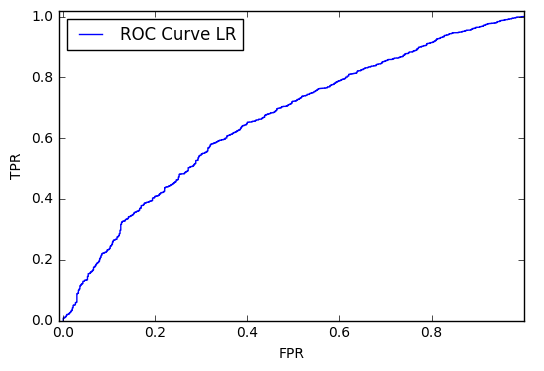

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure()

accuracy = lr.score(X_test, y_test.paid_off)
auc = roc_auc_score(y_test.paid_off, lr.predict_proba(X_test)[:, 1]) 
fpr, tpr, _ = roc_curve(y_test.paid_off, lr.predict_proba(X_test)[:, 1]) 
print("accuracy = {:.2f} AUC = {:.2f}".format(accuracy, auc))
plt.plot(fpr, tpr, label="ROC Curve LR")    
    
    
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

## Random Forest Classifier

Random Forest Classifier is versitale and can handle nonlinear and categorical data better than logistic regression. Since the data we have is mostly linear, I doubt there will be significant improvements to our model, but it's worth checking.

Mean: 0.99


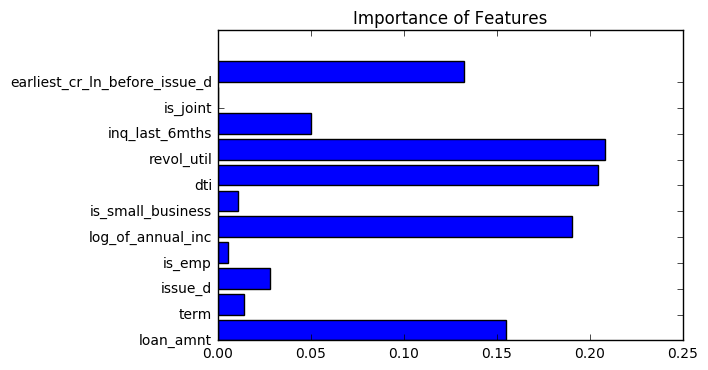

In [30]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators = 100, max_features='log2')
rf.fit(X_train, y_train.paid_off)

plt.barh(np.arange(len(rf.feature_importances_)), rf.feature_importances_)
plt.yticks(np.arange(len(rf.feature_importances_)), X.columns)
plt.title("Importance of Features")

print("Mean: {:.2f}".format(rf.predict(X_test).mean()))

plt.show()

It appears that the most significant features are revol_util, dti, and annual income. I'm surprised that employment isn't as significant.

Now let's use only the most important features.

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

X = X[['log_of_annual_inc', 'dti', 'loan_amnt', 'revol_util', 'earliest_cr_ln_before_issue_d', 'inq_last_6mths']]

X_train, X_test, y_train, y_test = train_test_split(X, y)



rf = RandomForestClassifier(n_estimators = 100, max_features='log2')
rf.fit(X_train, y_train.paid_off)


print(rf.feature_importances_)

[ 0.20480051  0.2284535   0.15944128  0.22561371  0.13468518  0.04700582]


Grades are assigned by the riskiness that LendingClub assesses so the probability of repayment decreases as the loan receives a lower grade.

In [33]:
loan_data.groupby('grade')['paid_off'].mean()

grade
A    0.946894
B    0.882751
C    0.848165
D    0.807525
E    0.771710
F    0.713855
G    0.695652
Name: paid_off, dtype: float64

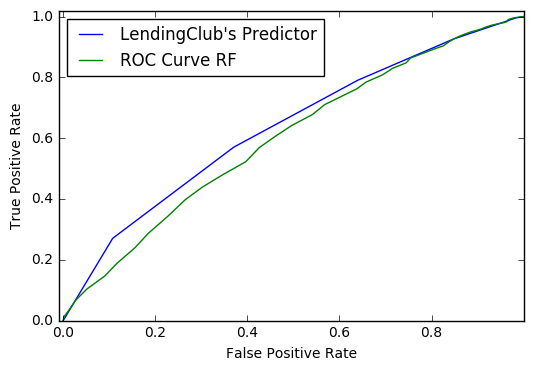

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

results = pd.DataFrame({'paid_off' : y_test['paid_off'],
                       'proba' : y_test.grade.map({'A': 95, 'B': 88, 'C': 85, 'D': 81, 'E': 77, 'F': 71, 'G': 70})})

plt.figure()
auc = roc_auc_score(results['paid_off'], results['proba'])
fpr, tpr, _ = roc_curve(results.paid_off, results.proba)
plt.plot(fpr, tpr, label="LendingClub's Predictor")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)

y = loan_data[['grade', 'paid_off']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y)



rf = RandomForestClassifier(n_estimators = 100, max_features = 4)
rf.fit(X_train, y_train.paid_off)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.paid_off, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.legend(loc="best")

The curve for LendingClub's ROC Curve is misleading. Rather than a smooth curve, it's a step function which jumps at each grade. Therefore, the ROC value is smaller than this.

In [35]:
lr = LogisticRegression()
lr.fit(X_train, y_train.paid_off)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

As predicted, the ROC of Random Forest classifier is only slightly better than Logistic Regression

In [36]:
print("LendingClub's ROC score: {:.3f}".format(roc_auc_score(y_test.paid_off, results['proba'])))
print("Logistic Regression ROC score: {:.3f}".format(roc_auc_score(y_test.paid_off, lr.predict_proba(X_test)[:, 1])))
print("Random Forest ROC score: {:.3f}".format(roc_auc_score(y_test.paid_off, rf.predict_proba(X_test)[:, 1])))

LendingClub's ROC score: 0.483
Logistic Regression ROC score: 0.580
Random Forest ROC score: 0.600


We initially chose variables arbitrarily for the Random Forest Classifier. A more precise using GridSearchCV method however doesn't improve the score significantly.

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10, 100, 1000],
             'max_features': [2, 3, 4]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring="roc_auc")
grid.fit(X_train, y_train.paid_off)

print("\nGrid-Search with AUC")
print("Best Parameters:", grid.best_params_)
print("Best cross-validation score(AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test.paid_off, grid.predict_proba(X_test)[:, 1])))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test.paid_off)))


Grid-Search with AUC
Best Parameters: {'max_features': 2, 'n_estimators': 1000}
Best cross-validation score(AUC): 0.605
Test set AUC: 0.603
Test set accuracy: 0.603


<a id='Conclusion'></a>

## Conclusion

Ultimately, we were successful in building a model to predict the likelihood of default and determining the most relavent indicators (revolving debt utilization, debt to income ratio, and annual income). Further analysis could develop a model for developing a portfolio that maximizes returns based on interest rate and probability of default.